In [73]:
import itertools
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os

from game import *
from random import randint
import networkx as nx

In [100]:
np.random.choice([0,1, 2], 2)

array([0, 0])

In [127]:
rules = Rules()
rules.nb_max_step = 100
rules.nb_players = 10

game1 = Game()
game1.rules = rules

player1 = Player()
player1.rules = rules
player1.type = EntityType.competitive_player

game1.add_player(player1)

game1.initialize_graph()

def get_game_graph(game):
    return np.float32(nx.adjacency_matrix(game.graph).todense())

def get_actions(game):
    return list(itertools.combinations(list(game.players.keys()), 2))

def get_action_space(game):
    actions = get_actions(game)
    return len(actions)

def get_input_space(game):
    return game.rules.nb_players**2

tf.reset_default_graph()
#These lines establish the feed-forward part of the network used to choose actions
action_space = get_action_space(game1)
input_space = get_input_space(game1)


class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        buffer = np.array(self.buffer)
        return buffer[np.random.choice(np.shape(buffer)[0], size, replace=False), :]
    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)
        

class Q_Network():
    def __init__(self):
        #These lines establish the feed-forward part of the network used to choose actions
        self.inputs = tf.placeholder(shape=[None, input_space],dtype=tf.float32)
        self.Temp = tf.placeholder(shape=None,dtype=tf.float32)
        self.keep_per = tf.placeholder(shape=None,dtype=tf.float32)

        hidden = slim.fully_connected(self.inputs,64,activation_fn=tf.nn.tanh,biases_initializer=None)
        hidden = slim.dropout(hidden,self.keep_per)
        self.Q_out = slim.fully_connected(hidden,action_space,activation_fn=None,biases_initializer=None)
        
        self.predict = tf.argmax(self.Q_out,1)
        self.Q_dist = tf.nn.softmax(self.Q_out/self.Temp)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,action_space,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), reduction_indices=1)
        
        self.nextQ = tf.placeholder(shape=[None],dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        trainer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.updateModel = trainer.minimize(loss)
        
# Set learning parameters
exploration = "e-greedy" #Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.
y = .99 #Discount factor.
num_episodes = 20000 #Total number of episodes to train network for.
tau = 0.001 #Amount to update target network at each step.
batch_size = 32 #Size of training batch
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 200000 #How many steps of training to reduce startE to endE.
pre_train_steps = 50000 #Number of steps used before training updates begin.


In [126]:
tf.reset_default_graph()

q_net = Q_Network()
target_net = Q_Network()

init = tf.global_variables_initializer()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)
myBuffer = experience_buffer()


#create lists to contain total rewards and steps per episode
jList = []
jMeans = []
rList = []
rMeans = []
with tf.Session() as sess:
    sess.run(init)
    updateTarget(targetOps,sess)
    e = startE
    stepDrop = (startE - endE)/anneling_steps
    total_steps = 0
    
    for i in range(num_episodes):
        #Reset environment and get first new observation
        if i % 10 == 0:
            print("Episode {}".format(i))
        rules = Rules()
        rules.nb_max_step = 100
        rules.nb_players = 10
        game1 = Game()
        game1.rules = rules
        player1 = Player()
        player1.name = "RL"
        player1.rules = rules
        player1.type = EntityType.competitive_player
        game1.add_player(player1)
        
        
        player2 = Player()
        player2.rules = rules
        player2.name = "Heuristic"
        player2.type = EntityType.competitive_player
        strategy_builder = StrategyBuilder()
        player2.strategy = strategy_builder.get_random_egoist_strategy()
        game1.add_player(player2)
        
        game1.initialize_graph()
        previous_centrality = 0
        s = get_game_graph(game1).flatten()
        rAll = 0
        d = False
        j = 0
        while j < rules.nb_max_step:
            j+=1
            if exploration == "greedy":
                #Choose an action with the maximum expected value.
                a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                a = a[0]
            if exploration == "random":
                #Choose an action randomly.
                a = np.random.randint(action_space)
            if exploration == "e-greedy":
                #Choose an action by greedily (with e chance of random action) from the Q-network
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    a = np.random.randint(action_space)
                else:
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                    a = a[0]
            if exploration == "boltzmann":
                #Choose an action probabilistically, with weights relative to the Q-values.
                Q_d,allQ = sess.run([q_net.Q_dist,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.Temp:e,q_net.keep_per:1.0})
                a = np.random.choice(Q_d[0],p=Q_d[0])
                a = np.argmax(Q_d[0] == a)
            if exploration == "bayesian":
                #Choose an action using a sample from a dropout approximation of a bayesian q-network.
                a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-e)+0.1})
                a = a[0]
            possible_actions = get_actions(game1)
            action = [possible_actions[a]]
            actions = list(game1.get_actions())
            action.extend(actions)
            game1.play_round(actions=action)
            s1 = get_game_graph(game1).flatten()
            centralities = nx.betweenness_centrality(game1.graph)
            centrality = centralities[0]
            if centrality == previous_centrality:
                r = 0
            elif centrality > previous_centrality:
                r = 1
            else:
                r = -1
            d = False
            myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            if e > endE and total_steps > pre_train_steps:
                e -= stepDrop
            
            if total_steps > pre_train_steps and total_steps % 5 == 0:
                #We use Double-DQN training algorithm
                trainBatch = myBuffer.sample(batch_size)
                Q1 = sess.run(q_net.predict,feed_dict={q_net.inputs:np.vstack(trainBatch[:,3]),q_net.keep_per:1.0})
                Q2 = sess.run(target_net.Q_out,feed_dict={target_net.inputs:np.vstack(trainBatch[:,3]),target_net.keep_per:1.0})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                _ = sess.run(q_net.updateModel,feed_dict={q_net.inputs:np.vstack(trainBatch[:,0]),q_net.nextQ:targetQ,q_net.keep_per:1.0,q_net.actions:trainBatch[:,1]})
                updateTarget(targetOps,sess)

            rAll += r
            s = s1
            total_steps += 1
            if d == True:
                break
        jList.append(j)
        rList.append(rAll)
        if i % 100 == 0 and i != 0:
            r_mean = np.mean(rList[-100:])
            j_mean = np.mean(jList[-100:])
            if exploration == 'e-greedy':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " e: " + str(e))
            if exploration == 'boltzmann':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " t: " + str(e))
            if exploration == 'bayesian':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
            if exploration == 'random' or exploration == 'greedy':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps))
            rMeans.append(r_mean)
            jMeans.append(j_mean)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Episode 0
Episode 10
Episode 20
Episode 30
Episode 40
Episode 50
Episode 60
Episode 70
Episode 80
Episode 90
Episode 100
Mean Reward: 78.95 Total Steps: 10100 e: 1
Episode 110
Episode 120
Episode 130
Episode 140
Episode 150
Episode 160
Episode 170
Episode 180
Episode 190
Episode 200
Mean Reward: 80.36 Total Steps: 20100 e: 1
Episode 210
Episode 220
Episode 230
Episode 240
Episode 250
Episode 260
Episode 270
Episode 280
Episode 290
Episode 300
Mean Reward: 81.0 Total Steps: 30100 e: 1
Episode 310
Episode 320
Episode 330
Episode 340
Episode 350
Episode 360
Episode 370
Episode 380
Episode 390
Episode 400
Mean Reward: 81.06 Total Steps: 40100 e: 1
Episode 410
Episode 420
Episode 430
Episode 440
Episode 450
Episode 460
Episode 470
Episode 480
Episode 490
Episode 500


ValueError: Cannot feed value of shape (32, 100) for Tensor 'Placeholder:0', which has shape '(1, 1, 100)'

Episode 0
Episode 10
Percent of succesful episodes: 3.7%


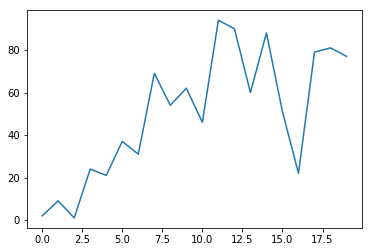

In [53]:
# Set learning parameters
y = .99
e = 0.1
num_episodes = 20
#create lists to contain total rewards and steps per episode
jList = []
rList = []
winList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        if i % 10 == 0:
            print("Episode {}".format(i))
        rules = Rules()
        rules.nb_max_step = 100
        rules.nb_players = 10
        game1 = Game()
        game1.rules = rules
        player1 = Player()
        player1.name = "RL"
        player1.rules = rules
        player1.type = EntityType.competitive_player
        game1.add_player(player1)
        
        
        player2 = Player()
        player2.rules = rules
        player2.name = "Heuristic"
        player2.type = EntityType.competitive_player
        strategy_builder = StrategyBuilder()
        player2.strategy = strategy_builder.get_random_egoist_strategy()
        game1.add_player(player2)
        
        game1.initialize_graph()
        
        s = get_game_graph(game1).flatten()
        
        rAll = 0
        previous_centrality = 0
        d = False
        j = 0
        win = 0
        #The Q-Network
        while j < rules.nb_max_step:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a, allQ = sess.run([predict,Qout],feed_dict={inputs1:s})
            if np.random.rand(1) < e:
                a[0] = np.random.randint(action_space)
            #Get new state and reward from environment
            action = None
            possible_actions = get_actions(game1)
            if a[0] is not 0:
                action = [possible_actions[a[0]]]
            else:
                action = None
            actions = list(game1.get_actions())
            action.extend(actions)
            game1.play_round(actions=action)
            s1 = get_game_graph(game1).flatten()
            centralities = nx.betweenness_centrality(game1.graph)
            centrality = centralities[0]
            if centrality == previous_centrality:
                r = 0
            elif centrality > previous_centrality:
                r = 1
            else:
                r = -1
            #print(centrality, previous_centrality, r)
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:s1})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:s,nextQ:targetQ})
            rAll += r
            s = s1
            previous_centrality = centrality
            
            opponent_centrality = centralities[1]
            if centrality > opponent_centrality:
                win += 1
            if centrality == 1.0 and j > 20:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        winList.append(win)
        jList.append(j)
        rList.append(rAll)
rList = np.array(rList)
print("Percent of succesful episodes: " + str(np.sum(rList)/num_episodes) + "%")

plt.plot(winList)